# Deep Learning

## Setup

In [26]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

from datasets import Dataset, DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score

In [2]:
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

generator = torch.Generator()
_ = generator.manual_seed(SEED)

In [3]:
all_label_strs = ['time_critical', 'support_and_relief', 'non_informative']
label2id = {label: i for i, label in enumerate(all_label_strs)}
id2label = {i: label for label, i in label2id.items()}

In [4]:
def load_data():
    df = {}
    for d in ['train', 'dev', 'test']:
        output_path = f"./data/crisisbench/preprocessed_data_{d}.csv"
        df[d] = pd.read_csv(output_path).loc[:, ['text', 'class_label_group', 'class_label_group_num']]
        print("Loading:", output_path)
    return df

df = load_data()

Loading: ./data/crisisbench/preprocessed_data_train.csv
Loading: ./data/crisisbench/preprocessed_data_dev.csv
Loading: ./data/crisisbench/preprocessed_data_test.csv


In [5]:
print(f"df_train: N={len(df['train'])}")
df['train'].head()

df_train: N=61089


,text,class_label_group,class_label_group_num
0,approximately km long firebreaks have been con...,time_critical,0
1,god bless you,non_informative,2
2,cracked wine casks damaged historical building...,time_critical,0
3,i m really just excited for new undies and pin...,non_informative,2
4,rescue effort e ands in india pakistan as floo...,time_critical,0


In [6]:
print(f"df_dev: N={len(df['dev'])}")
df['dev'].head()

df_dev: N=8921


,text,class_label_group,class_label_group_num
0,congrats to all my liverpool supporting fans f...,non_informative,2
1,collapsed buildings in mexico city earthquake ...,time_critical,0
2,here s your flower,non_informative,2
3,ready for a relaxing weekend but have too much...,non_informative,2
4,public private information portal developed to...,support_and_relief,1


In [7]:
print(f"df_test: N={len(df['test'])}")
df['test'].head()

df_test: N=17335


,text,class_label_group,class_label_group_num
0,staff at our feeding centre say chronic malnou...,support_and_relief,1
1,you comin down for the summer semesters right,non_informative,2
2,yea it s upstate i m like a few hours away,non_informative,2
3,teach every pakistani that it is not enough to...,non_informative,2
4,stay with for live cvg as typhoon hagupit slam...,time_critical,0


## CNN

### CNN Paper Setup
We train the CNN models using the Adam optimizer (Kingma and Ba 2014). The batch size is 128 and maximum number of epochs is set to 1000. We use a filter size of 300 with both window size and pooling length of 2, 3, and 4, and a dropout rate 0.02. We set early stopping
criterion based on the accuracy of the development set with a patience of 200. 

### Import Libraries

In [8]:

import math
from collections import Counter
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


### Hyperparameters

In [38]:
MAX_VOCAB_SIZE = 5000
MAX_SEQ_LEN = 64 # depends on tweet length
EMBED_DIM = 50
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 50
DROPOUT = 0.5 # tune
BATCH_SIZE = 64 # tune
LR = 1e-3
NUM_EPOCHS = 5
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
GLOVE_PATH = "data/crisisbench/glove_word_embeddings.txt"

### Tokenizer and Vocab

In [10]:
def simple_tokenize(text: str) -> List[str]:
    """
    Splits on whitespace
    """
    return text.strip().split()

def build_vocab(
    texts: List[str],
    max_size: int,
    min_freq: int = 1
) -> Dict[str, int]:
    """
    Build a word -> index vocab from training texts.
    Reserves index 0 for PAD and 1 for UNK.
    """
    counter = Counter()
    for text in texts:
        tokens = simple_tokenize(text)
        counter.update(tokens)

    vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}
    for word, freq in counter.most_common():
        if freq < min_freq:
            continue
        if len(vocab) >= max_size:
            break
        vocab[word] = len(vocab)

    return vocab


def encode_text(
    text: str,
    vocab: Dict[str, int],
    max_len: int
) -> List[int]:
    tokens = simple_tokenize(text)
    ids = [vocab.get(tok, vocab[UNK_TOKEN]) for tok in tokens][:max_len]
    if len(ids) < max_len:
        ids += [vocab[PAD_TOKEN]] * (max_len - len(ids))
    return ids


### Dataset & DataLoader

In [11]:
class TextDataset(Dataset):
    def __init__(
        self,
        texts: List[str],
        labels: List[int],
        vocab: Dict[str, int],
        max_len: int,
    ):
        assert len(texts) == len(labels)
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = encode_text(text, self.vocab, self.max_len)
        return torch.tensor(input_ids, dtype=torch.long), label


def create_dataloaders(
    train_texts: List[str],
    train_labels: List[int],
    val_texts: List[str],
    val_labels: List[int],
    max_vocab_size: int,
    max_seq_len: int,
    batch_size: int,
) -> Tuple[DataLoader, DataLoader, Dict[str, int], int]:
    vocab = build_vocab(train_texts, max_vocab_size)
    num_classes = len(set(train_labels))

    train_dataset = TextDataset(train_texts, train_labels, vocab, max_seq_len)
    val_dataset = TextDataset(val_texts, val_labels, vocab, max_seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, vocab, num_classes


### Load GloVe & build embedding matrix

In [12]:
def load_glove_embeddings(
    glove_path: str,
    embed_dim: int,
) -> Dict[str, torch.Tensor]:
    """
    Load GloVe file into a dict: word -> vector (torch.Tensor).
    Expects each line: word val1 val2 ... valD
    """
    embeddings = {}
    with open(glove_path, "r", encoding="utf8") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != embed_dim + 1:
                # ignore malformed lines
                continue
            word = parts[0]
            vec = torch.tensor([float(x) for x in parts[1:]], dtype=torch.float32)
            embeddings[word] = vec
    return embeddings


def build_embedding_matrix(
    vocab: Dict[str, int],
    glove_embeddings: Dict[str, torch.Tensor],
    embed_dim: int,
) -> torch.Tensor:
    """
    Create an embedding matrix of shape [vocab_size, embed_dim]
    where row i is the vector for the word with index i.
    Words not found in GloVe are randomly initialized (small normal).
    """
    vocab_size = len(vocab)
    embedding_matrix = torch.empty(vocab_size, embed_dim, dtype=torch.float32)

    # Initialize OOV embeddings to small random values
    torch.nn.init.normal_(embedding_matrix, mean=0.0, std=0.05)

    # Set PAD embedding to zeros
    pad_idx = vocab[PAD_TOKEN]
    embedding_matrix[pad_idx] = torch.zeros(embed_dim, dtype=torch.float32)

    oov_count = 0
    for word, idx in vocab.items():
        if word in (PAD_TOKEN, UNK_TOKEN):
            continue
        vec = glove_embeddings.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
        else:
            oov_count += 1

    print(f"GloVe OOV words: {oov_count}/{vocab_size}")
    return embedding_matrix

### Text CNN model (with optional pretrained embeddings)

In [ ]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        num_classes: int,
        pad_idx: int = 0,
        num_filters: int = 100,
        filter_sizes: Tuple[int, ...] = (3, 4, 5),
        dropout: float = 0.5,
        pretrained_embeddings: torch.Tensor | None = None,
        freeze_embeddings: bool = False,
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx,
        )

        if pretrained_embeddings is not None:
            if pretrained_embeddings.shape != (vocab_size, embed_dim):
                raise ValueError(
                    f"Pretrained embeddings shape {pretrained_embeddings.shape} "
                    f"does not match (vocab_size, embed_dim)=({vocab_size}, {embed_dim})"
                )
            self.embedding.weight.data.copy_(pretrained_embeddings)
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False

        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=num_filters,
                kernel_size=fs,
            )
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor:
        embedded = self.embedding(input_ids)          
        embedded = embedded.transpose(1, 2)           

        conv_outputs = []
        for conv in self.convs:
            x = conv(embedded)                        
            x = F.relu(x)
            x = F.max_pool1d(x, x.size(2)).squeeze(2)
            conv_outputs.append(x)

        cat = torch.cat(conv_outputs, dim=1)
        cat = self.dropout(cat)
        logits = self.fc(cat)
        return logits

### Training & Evaluation

In [40]:
def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_targets = []

    for input_ids, labels in dataloader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)

        preds = logits.argmax(dim=1)

        # accumulate predictions & ground truth
        all_preds.extend(preds.cpu().tolist())
        all_targets.extend(labels.cpu().tolist())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total if total > 0 else 0.0

    return avg_loss, accuracy, all_preds, all_targets


def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            preds = logits.argmax(dim=1)

            total_loss += loss.item() * x.size(0)
            total_correct += (preds == y).sum().item()
            total_examples += x.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_targets.extend(y.cpu().tolist())

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples

    return avg_loss, avg_acc, all_preds, all_targets



### Main CNN Train Script

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create loaders and vocab
train_loader, val_loader, vocab, num_classes = create_dataloaders(
    train_texts=df['train']['text'].to_list(),
    train_labels=df['train']['class_label_group_num'],
    val_texts=df['dev']['text'].to_list(),
    val_labels=df['dev']['class_label_group_num'],
    max_vocab_size=MAX_VOCAB_SIZE,
    max_seq_len=MAX_SEQ_LEN,
    batch_size=BATCH_SIZE,
)

print(f"Vocab size: {len(vocab)}, Num classes: {num_classes}")

# Load GloVe embeddings
print("Loading GloVe embeddings...")
glove_embeds = load_glove_embeddings(GLOVE_PATH, EMBED_DIM)
embedding_matrix = build_embedding_matrix(vocab, glove_embeds, EMBED_DIM)

# Initialize model with pretrained embeddings
print("Model Initialization...")
model = TextCNN(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    num_classes=num_classes,
    pad_idx=vocab[PAD_TOKEN],
    num_filters=NUM_FILTERS,
    filter_sizes=FILTER_SIZES,
    dropout=DROPOUT,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

best_val_f1 = 0.0

train_losses = []
train_accs = []
train_f1s = []
val_losses = []
val_accs = []
val_f1s = [] 

print("Training...")
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc, train_preds, train_targets = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    train_f1 = f1_score(train_targets, train_preds, average="macro")
    train_f1s.append(train_f1)
    val_loss, val_acc, val_preds, val_targets = evaluate(
        model, val_loader, criterion, device
    )
    val_f1 = f1_score(val_targets, val_preds, average="macro")
    val_f1s.append(val_f1)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "cnn/best_textcnn_glove.pt")

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
    )

print(f"Best validation f1: {best_val_f1:.4f}")

Vocab size: 5000, Num classes: 3
Loading GloVe embeddings...
GloVe OOV words: 58/5000
Model Initialization...
Training...
Epoch 01 | Train Loss: 0.4806, Train Acc: 0.8182, Train F1: 0.7485 | Val Loss: 0.3869, Val Acc: 0.8594, Val F1: 0.8057
Epoch 02 | Train Loss: 0.3846, Train Acc: 0.8579, Train F1: 0.8068 | Val Loss: 0.3602, Val Acc: 0.8673, Val F1: 0.8216
Epoch 03 | Train Loss: 0.3497, Train Acc: 0.8726, Train F1: 0.8272 | Val Loss: 0.3578, Val Acc: 0.8667, Val F1: 0.8163
Epoch 04 | Train Loss: 0.3233, Train Acc: 0.8810, Train F1: 0.8390 | Val Loss: 0.3513, Val Acc: 0.8701, Val F1: 0.8240
Epoch 05 | Train Loss: 0.3032, Train Acc: 0.8883, Train F1: 0.8494 | Val Loss: 0.3590, Val Acc: 0.8690, Val F1: 0.8215
Best validation f1: 0.8240


### Calculate Test Metrics

In [ ]:
from sklearn.metrics import f1_score

# load best model
model.load_state_dict(torch.load("cnn/best_textcnn_glove.pt", map_location=device))
model.to(device)

# build test loader
test_dataset = TextDataset(
    texts=df['test']['text'].to_list(),
    labels=df['test']['class_label_group_num'],
    vocab=vocab,
    max_len=MAX_SEQ_LEN,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# test loss + accuracy + preds
test_loss, test_acc, test_preds, test_targets = evaluate(
    model, test_loader, criterion, device
)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# compute ONLY F1 (macro)
test_f1 = f1_score(test_targets, test_preds, average="macro")
print(f"Test F1 (macro): {test_f1:.4f}")


Test Loss: 0.3600, Test Acc: 0.8700
Test F1 (macro): 0.8237


### Plot Learning and Validation Curves

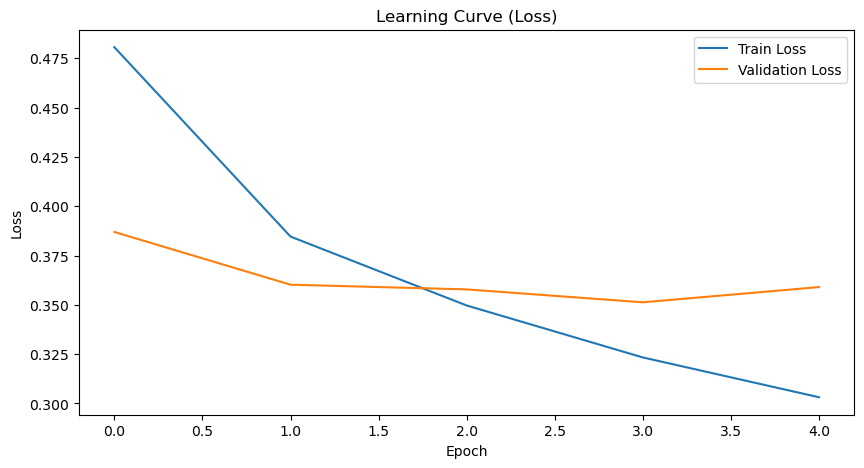

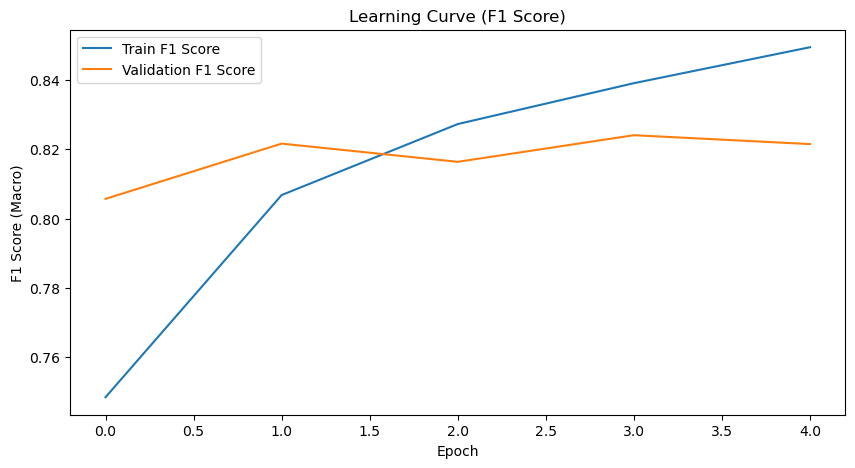

In [43]:
import matplotlib.pyplot as plt

# --- Loss plot ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve (Loss)")
plt.legend()
plt.savefig("cnn/cnn_loss_curve.png")

# --- F1 plot ---
plt.figure(figsize=(10, 5))
plt.plot(train_f1s, label="Train F1 Score")
plt.plot(val_f1s, label="Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score (Macro)")
plt.title("Learning Curve (F1 Score)")
plt.legend()
plt.savefig("cnn/cnn_f1_score_curve.png")

Training TextCNN with num_filters=25
Training TextCNN with num_filters=50
Training TextCNN with num_filters=75
Training TextCNN with num_filters=100


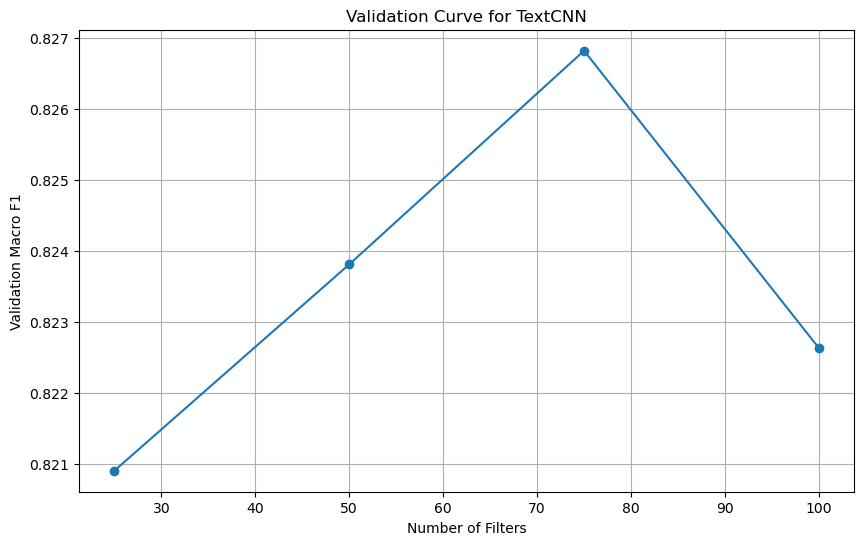

In [50]:
from sklearn.metrics import f1_score

filter_sizes_to_test = [25, 50, 75, 100]

val_scores = []

for num_filters in filter_sizes_to_test:
    print(f"Training TextCNN with num_filters={num_filters}")

    model = TextCNN(
        vocab_size=len(vocab),
        embed_dim=EMBED_DIM,
        num_classes=num_classes,
        pad_idx=vocab[PAD_TOKEN],
        num_filters=num_filters,
        filter_sizes=FILTER_SIZES,
        dropout=DROPOUT,
        pretrained_embeddings=embedding_matrix,
        freeze_embeddings=False,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    # Short training (hyperparameter search)
    EPOCHS = 5
    best_val_f1 = 0.0

    for _ in range(EPOCHS):
        train_one_epoch(model, train_loader, optimizer, criterion, device)

        # IMPORTANT: return preds + targets
        val_loss, val_acc, val_preds, val_targets = evaluate(
            model, val_loader, criterion, device
        )

        # compute F1 macro
        val_f1 = f1_score(val_targets, val_preds, average="macro")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1

    val_scores.append(best_val_f1)


# ---- Plot ----
plt.figure(figsize=(10, 6))
plt.plot(filter_sizes_to_test, val_scores, marker="o")
plt.xlabel("Number of Filters")
plt.ylabel("Validation Macro F1")
plt.title("Validation Curve for TextCNN")
plt.grid(True)
plt.savefig("cnn/cnn_num_filters_f1_curve.png")
plt.show()


## Transformer

### Model

In [52]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_labels = 3,
        max_length = 64,
        d_model = 256, # hidden size
        nhead = 4, # number of attention heads
        num_layers = 2, # number of encoder layers
        dim_feedforward = 512,  # FFN inner dim
        dropout = 0.3,
    ):
        super().__init__()
        self.d_model = d_model
        self.max_length = max_length

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_length, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True, # (batch, seq, dim)
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.layer_norm = nn.LayerNorm(d_model)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_labels),
        )

    def forward(self, input_ids, attention_mask):
        batch_size, seq_len = input_ids.size()
        if seq_len > self.max_length:
            raise ValueError(f"seq_len {seq_len} > max_length {self.max_length}")

        token_emb = self.token_embedding(input_ids)  # (B, L, D)

        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)  # (1, L)
        pos_emb = self.pos_embedding(positions)  # (1, L, D)

        x = token_emb + pos_emb  # (B, L, D)

        src_key_padding_mask = (attention_mask == 0)  # (B, L), bool

        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)  # (B, L, D)
        x = self.layer_norm(x)

        mask = attention_mask.unsqueeze(-1)  # (B, L, 1)
        masked_x = x * mask  # (B, L, D)

        lengths = mask.sum(dim=1).clamp(min=1)  # (B, 1)
        pooled = masked_x.sum(dim=1) / lengths  # (B, D)

        logits = self.classifier(pooled)  # (B, num_labels)
        return logits

In [53]:
def compute_metrics_from_preds(all_logits, all_labels):
    logits = np.concatenate(all_logits, axis=0)
    labels = np.concatenate(all_labels, axis=0)

    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="macro",
        zero_division=0,
    )
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

### Tokenizer

In [54]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from datasets import Dataset, DatasetDict

train_texts = df["train"]["text"].tolist()
dev_texts   = df["dev"]["text"].tolist()
test_texts   = df["test"]["text"].tolist()

tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(
    vocab_size=30000, # could be adjusted
    min_frequency=2,
    special_tokens=special_tokens,
)

tokenizer.train_from_iterator(train_texts, trainer=trainer)

max_length = 64
pad_id = tokenizer.token_to_id("[PAD]")

tokenizer.enable_truncation(max_length=max_length)
tokenizer.enable_padding(
    length=max_length,
    pad_id=pad_id,
    pad_token="[PAD]",
)

def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids = [e.ids for e in encodings]
    attention_mask = [e.attention_mask for e in encodings]
    return {"input_ids": input_ids, "attention_mask": attention_mask}

train_enc = encode_batch(train_texts)
dev_enc   = encode_batch(dev_texts)
test_enc   = encode_batch(test_texts)

train_dataset = Dataset.from_dict({
    "input_ids":      train_enc["input_ids"],
    "attention_mask": train_enc["attention_mask"],
    "label":          df["train"]["class_label_group_num"].tolist(),
})
val_dataset = Dataset.from_dict({
    "input_ids":      dev_enc["input_ids"],
    "attention_mask": dev_enc["attention_mask"],
    "label":          df["dev"]["class_label_group_num"].tolist(),
})
test_dataset = Dataset.from_dict({
    "input_ids":      test_enc["input_ids"],
    "attention_mask": test_enc["attention_mask"],
    "label":          df["test"]["class_label_group_num"].tolist(),
})

tokenized_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

tokenized_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"],
)

### Plot Curves Using Best Model

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torch.optim import AdamW

# Fixed hyperparameters for this run
D_MODEL = 256
NUM_LAYERS = 2
DROPOUT = 0.3
LR = 3e-4
BATCH_SIZE = 32
NHEAD = 4
DIM_FEEDFORWARD = 512
WEIGHT_DECAY = 0.01
MAX_LENGTH = 64
MAX_EPOCHS = 4  # for the learning curve

num_labels = len(label2id)
vocab_size = tokenizer.get_vocab_size()

# Build DataLoaders
train_loader = DataLoader(
    tokenized_datasets["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_loader = DataLoader(
    tokenized_datasets["validation"],
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=BATCH_SIZE,
    shuffle=False,
)

def evaluate_model(model, data_loader):
    model.eval()
    val_loss = 0.0
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            all_logits.append(logits.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

    val_loss /= len(data_loader)
    metrics = compute_metrics_from_preds(all_logits, all_labels)
    metrics["loss"] = val_loss
    return metrics

# =========================
# 1) Learning curve (F1 vs epoch, 1–4)
# =========================
model = TransformerClassifier(
    vocab_size=vocab_size,
    num_labels=num_labels,
    max_length=MAX_LENGTH,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
).to(device)

optimizer = AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

learning_curve_f1 = []

for epoch in range(1, MAX_EPOCHS + 1):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Evaluate on validation set
    val_metrics = evaluate_model(model, val_loader)
    learning_curve_f1.append(val_metrics["f1"])

    print(f"Epoch {epoch}/{MAX_EPOCHS}")
    print(f"  train_loss = {avg_train_loss:.4f}")
    print(f"  val_loss   = {val_metrics['loss']:.4f}")
    print(f"  val_acc    = {val_metrics['accuracy']:.4f}")
    print(f"  val_f1     = {val_metrics['f1']:.4f}")

# Final test metrics for this config
test_metrics = evaluate_model(model, test_loader)
print("\nTest metrics for fixed config:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

# Plot learning curve (val macro F1 vs epoch)
plt.figure(figsize=(8, 5))
epochs = list(range(1, MAX_EPOCHS + 1))
plt.plot(epochs, learning_curve_f1, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation F1 (macro)")
plt.title("Learning Curve (Transformer, d_model=256, layers=2, dropout=0.3)")
plt.grid(True)
plt.tight_layout()
plt.savefig("transformer_learning_curve_f1.png")
plt.show()

# =========================
# 2) Validation curve over learning rate (F1 vs lr)
# =========================

LR_VALUES = [1e-4, 3e-4, 1e-3]
VAL_F1_PER_LR = []

for lr in LR_VALUES:
    print(f"\n=== Validation curve run: lr={lr} ===")
    # fresh model each time
    model_lr = TransformerClassifier(
        vocab_size=vocab_size,
        num_labels=num_labels,
        max_length=MAX_LENGTH,
        d_model=D_MODEL,
        nhead=NHEAD,
        num_layers=NUM_LAYERS,
        dim_feedforward=DIM_FEEDFORWARD,
        dropout=DROPOUT,
    ).to(device)

    optimizer_lr = AdamW(
        model_lr.parameters(),
        lr=lr,
        weight_decay=WEIGHT_DECAY,
    )

    best_val_f1 = 0.0
    EPOCHS_LR = 3  # small number for hyperparam sweep

    for epoch in range(1, EPOCHS_LR + 1):
        model_lr.train()
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer_lr.zero_grad()
            logits = model_lr(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer_lr.step()

        val_metrics_lr = evaluate_model(model_lr, val_loader)
        best_val_f1 = max(best_val_f1, val_metrics_lr["f1"])
        print(f"  epoch {epoch}/{EPOCHS_LR}: val_f1={val_metrics_lr['f1']:.4f}")

    VAL_F1_PER_LR.append(best_val_f1)
    print(f"Best val F1 for lr={lr}: {best_val_f1:.4f}")

# Plot validation curve (best val F1 vs learning rate)
plt.figure(figsize=(8, 5))
plt.plot(LR_VALUES, VAL_F1_PER_LR, marker="o")
plt.xscale("log")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Best Validation F1 (macro)")
plt.title("Validation Curve (Transformer, learning rate)")
plt.grid(True)
plt.tight_layout()
plt.savefig("transformer_lr_validation_curve_f1.png")
plt.show()
